In [1]:
#!!!!!!!!this script is just used for validate encode and decode boxes
import tensorflow as tf
import numpy as np
from util import *
import os
import matplotlib.pyplot as plt
from losses import *
from flags_and_variables import *
from encode_boxes import *
from fcos import *
import random

In [2]:
annotation_2007 = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/train/txt/diningtable.txt')
# annotation_2012 = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2012/txt/diningtable.txt')
annotation = annotation_2007
train_iter = read_data(annotation,FLAGS.batch_size,input_shape=(800,1024),is_random=False,is_crop=False)

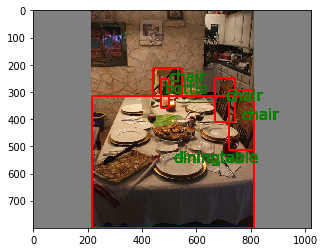

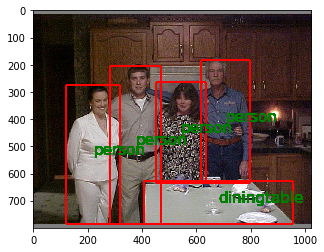

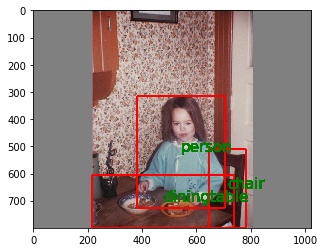

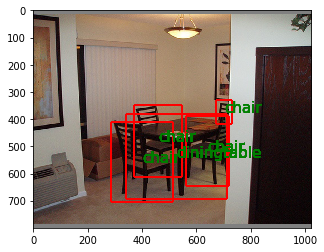

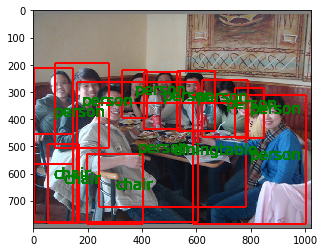

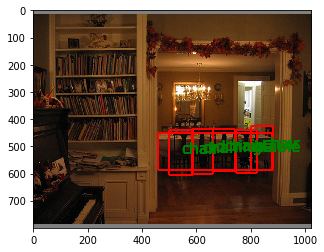

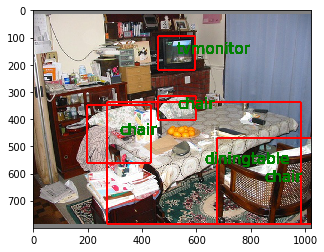

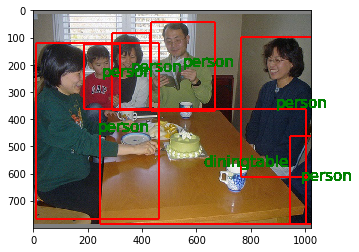

In [9]:
image_batch,annotation_batch,cls_batch = next(train_iter)
#one hot for cls_batch
eye = np.eye(20)
eye = np.concatenate([eye,np.expand_dims(np.zeros_like(eye[0]),axis=0)])
cls_batch = eye[(cls_batch-1).astype(np.int32)].astype(np.float32)

matched_true_boxes,matched_true_classes,matched_true_centerness = encode_boxes_PANET(annotation_batch,cls_batch,feature_size,stride,concatenate=True)
feature_state = np.squeeze(matched_true_centerness!=0,axis=-1)



center_list = []
offset = np.math.floor(stride[0]/2)
y_center_mapping = np.array([(j*stride[0]+offset) for j in range(feature_size[0][0])])
x_center_mapping = np.array([(j*stride[0]+offset) for j in range(feature_size[0][1])])
y_center_mapping = np.expand_dims(np.tile(np.expand_dims(y_center_mapping,axis=-1),[1,feature_size[0][1]]),axis=-1)
x_center_mapping = np.expand_dims(np.tile(np.expand_dims(x_center_mapping,axis=0),[feature_size[0][0],1]),axis=-1)
center_list = np.concatenate([y_center_mapping,x_center_mapping],axis=-1).reshape(-1,(feature_size[0][0]*feature_size[0][1]),2)


ymin = np.expand_dims((center_list[...,0]-matched_true_boxes[...,0]* FLAGS.image_height) ,axis=-1)
ymax = np.expand_dims((center_list[...,0]+matched_true_boxes[...,1]* FLAGS.image_height) ,axis=-1)
xmin = np.expand_dims((center_list[...,1]-matched_true_boxes[...,2]* FLAGS.image_width) ,axis=-1)
xmax = np.expand_dims((center_list[...,1]+matched_true_boxes[...,3]* FLAGS.image_width) ,axis=-1)
localization_pred = np.concatenate([ymin,xmin,ymax,xmax],axis=-1)

for i in range(FLAGS.batch_size):
    mask = feature_state[i]>0
    temp_localization_pred = localization_pred[i][mask]
    temp_matched_true_classes = matched_true_classes[i][mask]
    ymin,xmin,ymax,xmax = np.split(temp_localization_pred,axis=-1,indices_or_sections=4)
    for j in range(temp_matched_true_classes.shape[0]):
        position = ((ymin[j]+ymax[j])/2,(xmin[j]+xmax[j])/2)
        plt.text(position[1],position[0],corresponding_dict[np.argmax(temp_matched_true_classes[j])],color='g',size = 15)
    plt.hlines(ymin,xmin,xmax,'r')
    plt.hlines(ymax,xmin,xmax,'r')
    plt.vlines(xmin,ymin,ymax,'r')
    plt.vlines(xmax,ymin,ymax,'r')
    plt.imshow(image_batch[i])
    plt.show()
    

In [4]:
matched_true_classes.shape

(6, 800, 20)

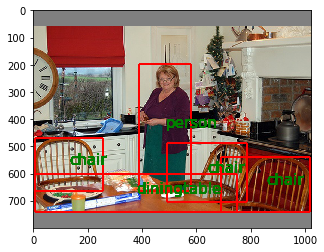

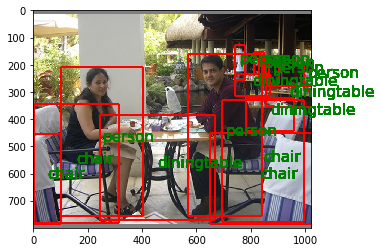

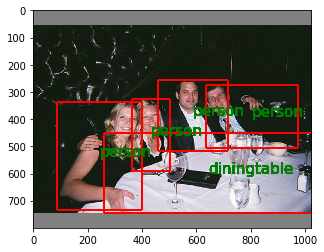

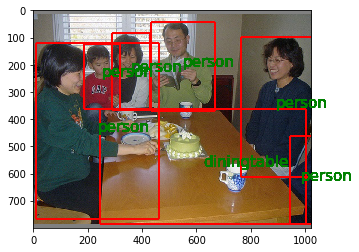

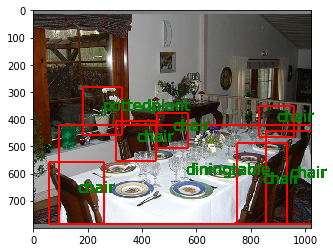

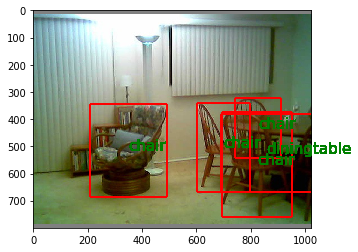

In [9]:
image_batch,annotation_batch,cls_batch = next(train_iter)
#one hot for cls_batch
eye = np.eye(20)
eye = np.concatenate([eye,np.expand_dims(np.zeros_like(eye[0]),axis=0)])
cls_batch = eye[(cls_batch-1).astype(np.int32)].astype(np.float32)

matched_true_boxes,matched_true_classes,matched_true_centerness = encode_boxes(annotation_batch,cls_batch,feature_size,stride,concatenate=True)
feature_state = np.squeeze(matched_true_centerness!=0,axis=-1)

m_w = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_width
m_h = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_height
center_list = []
m_h_min_list = []
m_w_max_list = []
for i in range(5):
    #change top,bottom,left,right to ymin,xmin,ymax,xmax
# feature_size=[(100,128),(50,64),(25,32),(13,16),(7,8)]
# stride=[8,16,32,64,128]
    m_w_min =m_w[i]
    m_w_max =m_w[i+1]
    m_h_min =m_h[i]
    m_h_max =m_h[i+1]
    #ensure the predicted boxes max(top,bottom,left,right) is in the domain(m_h_min,m_w_max)
        #the mim(top,bottom,left,right) is bigger than 1 pixel
    offset = np.math.floor(stride[i]/2)
    y_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][0])])/FLAGS.image_height
    x_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][1])])/FLAGS.image_width
    y_center_mapping = np.expand_dims(np.tile(np.expand_dims(y_center_mapping,axis=-1),[1,feature_size[i][1]]),axis=-1)
    x_center_mapping = np.expand_dims(np.tile(np.expand_dims(x_center_mapping,axis=0),[feature_size[i][0],1]),axis=-1)
    center = np.concatenate([y_center_mapping,x_center_mapping],axis=-1).reshape(-1,(feature_size[i][0]*feature_size[i][1]),2)
    center_list.append(center)
    m_h_min = np.ones_like(y_center_mapping)*m_h_min
    m_w_max = np.ones_like(x_center_mapping)*m_w_max
    m_h_min_list.append(m_h_min.reshape(-1,(feature_size[i][0]*feature_size[i][1])))
    m_w_max_list.append(m_w_max.reshape(-1,(feature_size[i][0]*feature_size[i][1])))
center_list = np.concatenate(center_list,axis=1) #(1, 17064, 2)
m_h_min_list = np.concatenate(m_h_min_list,axis=1)#(1, 17064)
m_w_max_list = np.concatenate(m_w_max_list,axis=1)#(1, 17064)

#     localization_mask = tf.expand_dims(tf.logical_and((tf.reduce_min(localization_pred,axis=-1)>m_h_min_list),(tf.reduce_max(localization_pred,axis=-1)<=m_w_max_list)),axis=-1)
#     localization_mask = tf.cast(localization_mask,tf.float32) * tf.cast(tf.expand_dims((tf.reduce_min(localization_pred,axis=-1)>0.001),axis=-1),tf.float32)
#     localization_pred = localization_pred * localization_mask
#     centerness_pred  = centerness_pred *localization_mask
#     classes_pred = classes_pred * localization_mask

ymin = np.expand_dims((center_list[...,0]-matched_true_boxes[...,0]) * FLAGS.image_height,axis=-1)
ymax = np.expand_dims((center_list[...,0]+matched_true_boxes[...,1]) * FLAGS.image_height,axis=-1)
xmin = np.expand_dims((center_list[...,1]-matched_true_boxes[...,2]) * FLAGS.image_width,axis=-1)
xmax = np.expand_dims((center_list[...,1]+matched_true_boxes[...,3]) * FLAGS.image_width,axis=-1)
localization_pred = np.concatenate([ymin,xmin,ymax,xmax],axis=-1)
# centerness_pred = tf.squeeze(centerness_pred,axis=0)
# classes_pred = tf.squeeze(classes_pred,axis=0)
# localization_pred = np.squeeze(localization_pred,axis=0)
for i in range(FLAGS.batch_size):
    mask = feature_state[i]>0
    temp_localization_pred = localization_pred[i][mask]
    temp_matched_true_classes = matched_true_classes[i][mask]
    ymin,xmin,ymax,xmax = np.split(temp_localization_pred,axis=-1,indices_or_sections=4)
    for j in range(temp_matched_true_classes.shape[0]):
        position = ((ymin[j]+ymax[j])/2,(xmin[j]+xmax[j])/2)
        plt.text(position[1],position[0],corresponding_dict[np.argmax(temp_matched_true_classes[j])],color='g',size = 15)
    plt.hlines(ymin,xmin,xmax,'r')
    plt.hlines(ymax,xmin,xmax,'r')
    plt.vlines(xmin,ymin,ymax,'r')
    plt.vlines(xmax,ymin,ymax,'r')
    plt.imshow(image_batch[i])
    plt.show()

In [15]:
p1 = matched_true_boxes[0][0:12800]
p2 = matched_true_boxes[0][12800:(12800+3200)]
p3 = matched_true_boxes[0][(12800+3200):(12800+3200+800)]
p4 = matched_true_boxes[0][(12800+3200+800):(12800+3200+800+208)]
p5 = matched_true_boxes[0][(12800+3200+800+208):(12800+3200+800+208+56)]

In [23]:
p5

array([[-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , -0.        ],
       [-0.        ,  0.

In [21]:
temp = matched_true_classes[0][(12800+3200+800+208):(12800+3200+800+208+56)]

In [28]:
temp[-14]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [5]:
# import tensorflow as tf
# import numpy as np
# from util import *
# import os
# import matplotlib.pyplot as plt
# from tensorflow.python.ops import control_flow_ops
# from losses import *
# from flags_and_variables import *
# from encode_boxes import *
# from fcos import *
# from tensorpack.tfutils.optimizer import AccumGradOptimizer
# import random

# x = tf.get_variable('x', shape=[6])
# cost = tf.reduce_sum(tf.abs(x), name='cost')
# opt = tf.train.GradientDescentOptimizer(0.01)
# opt = AccumGradOptimizer(opt, 5)
# min_op = opt.minimize(cost, global_step=tf.train.get_or_create_global_step())

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# with sess.as_default():
#     for k in range(20):
#         min_op.run()
#         print(x.eval())
#         print(tf.train.get_or_create_global_step().eval())

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [ ]:
def predict_outputs(centerness_pred,classes_pred,localization_pred,feature_size):
    m_w = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_width
    m_h = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_height
    center_list = []
    m_h_min_list = []
    m_w_max_list = []
    for i in range(5):
        #change top,bottom,left,right to ymin,xmin,ymax,xmax
    # feature_size=[(100,128),(50,64),(25,32),(13,16),(7,8)]
    # stride=[8,16,32,64,128]
        m_w_min =m_w[i]
        m_w_max =m_w[i+1]
        m_h_min =m_h[i]
        m_h_max =m_h[i+1]
        #ensure the predicted boxes max(top,bottom,left,right) is in the domain(m_h_min,m_w_max)
            #the mim(top,bottom,left,right) is bigger than 1 pixel
        offset = np.math.floor(stride[i]/2)
        y_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][0])])/FLAGS.image_height
        x_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][1])])/FLAGS.image_width
        y_center_mapping = np.expand_dims(np.tile(np.expand_dims(y_center_mapping,axis=-1),[1,feature_size[i][1]]),axis=-1)
        x_center_mapping = np.expand_dims(np.tile(np.expand_dims(x_center_mapping,axis=0),[feature_size[i][0],1]),axis=-1)
        center = np.concatenate([y_center_mapping,x_center_mapping],axis=-1).reshape(-1,(feature_size[i][0]*feature_size[i][1]),2)
        center_list.append(center)
        m_h_min = np.ones_like(y_center_mapping)*m_h_min
        m_w_max = np.ones_like(x_center_mapping)*m_w_max
        m_h_min_list.append(m_h_min.reshape(-1,(feature_size[i][0]*feature_size[i][1])))
        m_w_max_list.append(m_w_max.reshape(-1,(feature_size[i][0]*feature_size[i][1])))
    center_list = np.concatenate(center_list,axis=1) #(1, 17064, 2)
    m_h_min_list = np.concatenate(m_h_min_list,axis=1)#(1, 17064)
    m_w_max_list = np.concatenate(m_w_max_list,axis=1)#(1, 17064)
    
#     localization_mask = tf.expand_dims(tf.logical_and((tf.reduce_min(localization_pred,axis=-1)>m_h_min_list),(tf.reduce_max(localization_pred,axis=-1)<=m_w_max_list)),axis=-1)
    localization_mask_2 = tf.cast(tf.expand_dims((tf.reduce_min(localization_pred,axis=-1)>0.001),axis=-1),tf.float32)
#     localization_mask = tf.cast(localization_mask,tf.float32) * localization_mask_2
    localization_pred = localization_pred * localization_mask_2
    centerness_pred  = centerness_pred *localization_mask_2
    classes_pred = classes_pred * localization_mask_2
    
    
    ymin = tf.expand_dims((center_list[...,0]-localization_pred[...,0]) * FLAGS.image_height,axis=-1)
    ymax = tf.expand_dims((center_list[...,0]+localization_pred[...,1]) * FLAGS.image_height,axis=-1)
    xmin = tf.expand_dims((center_list[...,1]-localization_pred[...,2]) * FLAGS.image_width,axis=-1)
    xmax = tf.expand_dims((center_list[...,1]+localization_pred[...,3]) * FLAGS.image_width,axis=-1)
    localization_pred = tf.concat([ymin,xmin,ymax,xmax],axis=-1)
    centerness_pred = tf.squeeze(centerness_pred,axis=0)
    classes_pred = tf.squeeze(classes_pred,axis=0)
    localization_pred = tf.squeeze(localization_pred,axis=0)
    
    score_pred = centerness_pred*classes_pred
#     score_pred = classes_pred
    mask = (score_pred > inference_threshold)
    
    _boxes = []
    _classes = []
    _scores = []
    for c in range(FLAGS.num_class):
    ##nms
        _localization_pred = tf.boolean_mask(localization_pred,mask[:,c])
        _scores_pred = tf.boolean_mask(score_pred[:,c],mask[:,c])
        nms_index = tf.image.non_max_suppression(
            _localization_pred, _scores_pred, 10, iou_threshold = 0.5)
        _boxes.append(tf.gather(_localization_pred, nms_index))
        _scores_pred = tf.gather(_scores_pred,nms_index)
        _scores.append(_scores_pred)
        _classes.append(tf.ones_like(_scores_pred, 'int32') * c)
    _boxes = tf.concat(_boxes,axis=0)
    _scores = tf.concat(_scores,axis=0)
    _classes = tf.concat(_classes,axis=0)
    return _scores,_classes,_boxes